# **Experiment #1**: Epoch length

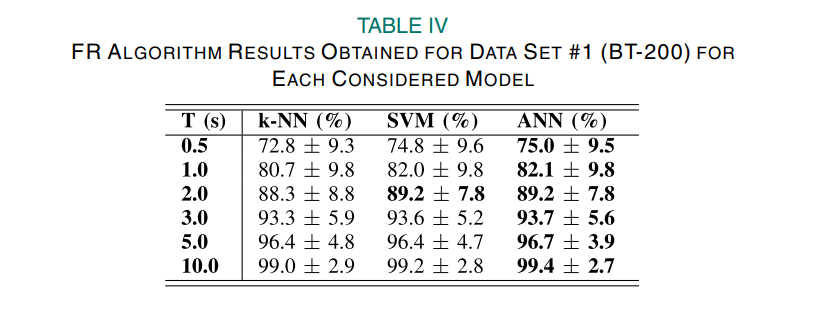

In [28]:
import mne

# Utility
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
# Scikit-learn and Pyriemann ML functionalities
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
from pyriemann.estimation import Covariances, ERPCovariances, XdawnCovariances
from pyriemann.spatialfilters import CSP
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM

from utilities import read_xdf, epoching

### **Load Data**

In [1]:
DATA = dict()

T = {0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 10.0} # epoch period in second

In [ ]:
filenames = {'Pipo_1_5_test1.xdf', 'Pipo_1_5_test2.xdf', 'Pipo_1_5_test3.xdf'}

for tmax in T:

    X, F, t, y = [],[],[],[]
    for filename in filenames:

        raw = read_xdf(filename, show_plot=False, show_psd=False, bandpass=(4.0, 12.0))

        epochs = epoching(raw, show_psd=False,
            show_eeg=False,    # set True if wanna see preview of all epoch
            tmax=tmax)         # tmax=5 means set epoch duration 5 second

        # Pick only event 2: Left stimuli, 5: Right stimuli
        epochs = epochs['2','5']

        X.append((  epochs.get_data() * 1e6)[:,:,:int( tmax*250 )]) # 250 is record sampling rate
        t.append((  epochs.times)[:int( tmax*250 )]) # 250 is record sampling rate          
        F.append(   epochs.compute_psd(
            method='welch', 
            fmax=30,
            n_per_seg=len(epochs.times),
            '''
            raise ValueError(('If n_per_seg is None n_fft is not allowed to be > ''n_times. 
            If you want zero-padding, you have to set ''n_per_seg to relevant length. Got n_fft of %d while'' signal length is %d.') % (n_fft, n))

            n_fft : int
                The length of FFT used, must be ``>= n_per_seg`` (default: 256).
                The segments will be zero-padded if ``n_fft > n_per_seg``.
            n_per_seg : int | None
                Length of each Welch segment. The smaller it is with respect to the
                signal length the smoother are the PSDs. Defaults to None, which sets
                n_per_seg equal to n_fft.
            '''
            ).get_data())
        y.append(   epochs.events[:, -1])

    # Concatenate all data
    X = np.concatenate(X)
    F = np.concatenate(F)
    t = np.concatenate(t)
    y = np.concatenate(y)

    DATA[str(tmax)] = (X, F, t, y)

In [22]:
print("DATA:", DATA.keys())

for key in DATA.keys():
    X, F, t, y = DATA[key]
    print(f"T={key} :", X.shape, F.shape, t.shape, y.shape)

DATA: dict_keys(['0.5', '1.0', '2.0', '3.0', '4.0', '5.0', '10.0'])
T=0.5 : (48, 5, 125) (48, 5, 31) (375,) (48,)
T=1.0 : (48, 5, 250) (48, 5, 31) (750,) (48,)
T=2.0 : (48, 5, 500) (48, 5, 31) (1500,) (48,)
T=3.0 : (48, 5, 750) (48, 5, 31) (2250,) (48,)
T=4.0 : (48, 5, 1000) (48, 5, 31) (3000,) (48,)
T=5.0 : (48, 5, 1250) (48, 5, 31) (3750,) (48,)
T=10.0 : (48, 5, 2500) (48, 5, 31) (7500,) (48,)


## **Cross-validation**

In [36]:
from sklearn.metrics import mean_absolute_error as mae


Epoch length(T)=0.5
 CSP + RegLDA    :Standard error=0.019, Mean=0.594, Max=0.156, Min=-0.150
 Cov + TS        :Standard error=0.026, Mean=0.618, Max=0.215, Min=-0.174
 Cov + MDM       :Standard error=0.029, Mean=0.594, Max=0.294, Min=-0.178
 CSP + Cov + TS  :Standard error=0.028, Mean=0.653, Max=0.208, Min=-0.181

Epoch length(T)=1.0
 CSP + RegLDA    :Standard error=0.030, Mean=0.758, Max=0.242, Min=-0.286
 Cov + TS        :Standard error=0.027, Mean=0.747, Max=0.169, Min=-0.219
 Cov + MDM       :Standard error=0.025, Mean=0.735, Max=0.265, Min=-0.235
 CSP + Cov + TS  :Standard error=0.033, Mean=0.771, Max=0.229, Min=-0.382

Epoch length(T)=2.0
 CSP + RegLDA    :Standard error=0.018, Mean=0.832, Max=0.112, Min=-0.165
 Cov + TS        :Standard error=0.022, Mean=0.835, Max=0.165, Min=-0.168
 Cov + MDM       :Standard error=0.022, Mean=0.835, Max=0.165, Min=-0.168
 CSP + Cov + TS  :Standard error=0.020, Mean=0.829, Max=0.115, Min=-0.163

Epoch length(T)=3.0
 CSP + RegLDA    :Standard e

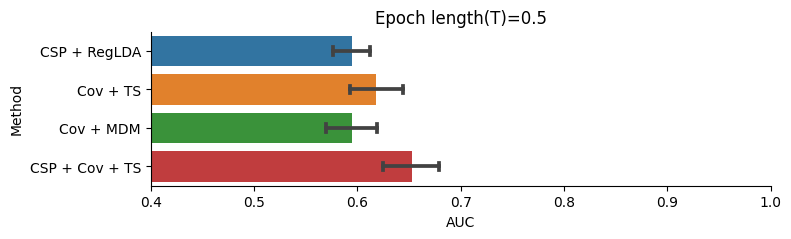

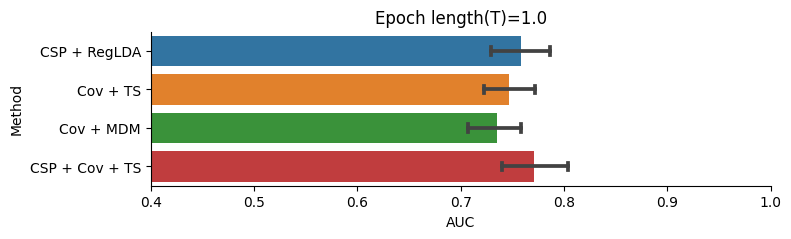

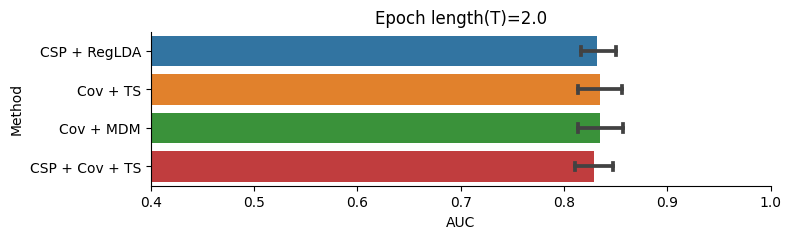

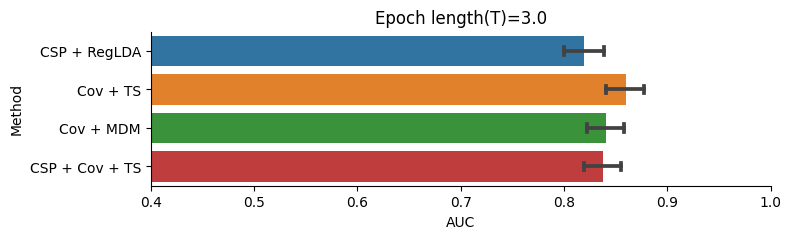

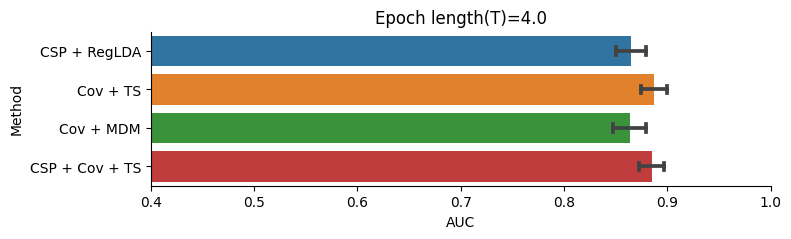

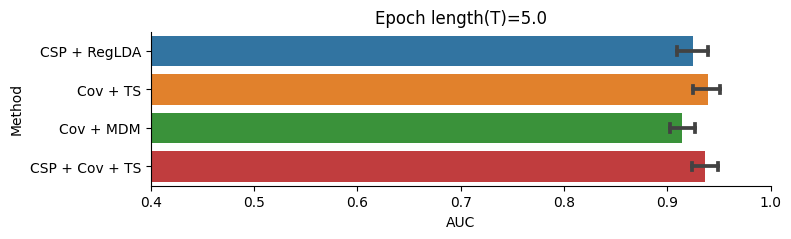

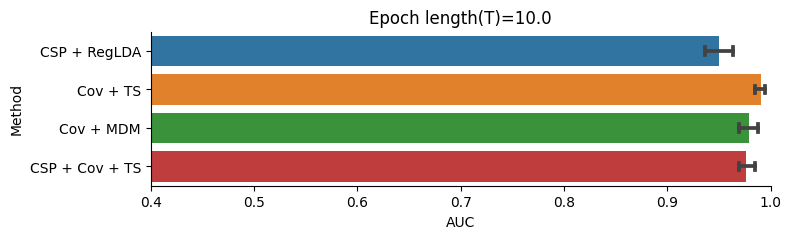

In [49]:
RESULTS = pd.DataFrame()

for key in DATA.keys():
    X, F, t, y = DATA[key]

    # Next, we will use 4 different machine learning pipelines to classify the SSVEP based on the data we collected. The

    # - CSP + RegLDA : Common Spatial Patterns + Regularized Linear Discriminat Analysis. This is a very common EEG analysis pipeline.
    # - Cov + TS : Covariance + Tangent space mapping. One of the most reliable Riemannian geometry-based pipelines.
    # - Cov + MDM: Covariance + MDM. A very simple, yet effective (for low channel count), Riemannian geometry classifier.
    # - CSP + Cov + TS: Common Spatial Patterns + Covariance + Tangent spacem mapping. Riemannian pipeline with the standard CSP procedure beforehand

    # Evaluation is done through cross-validation, with area-under-the-curve (AUC) as metric (AUC is probably the best metric for binary and unbalanced classification problem)

    # Note: because we're doing machine learning here, the following cell may take a while to complete

    clfs = OrderedDict()
    clfs['CSP + RegLDA'] = make_pipeline(Covariances(), CSP(4), LDA(shrinkage='auto', solver='eigen'))
    clfs['Cov + TS'] = make_pipeline(Covariances(), TangentSpace(), LogisticRegression())
    clfs['Cov + MDM'] = make_pipeline(Covariances(), MDM())
    clfs['CSP + Cov + TS'] = make_pipeline(Covariances(), CSP(4, log=False), TangentSpace(), LogisticRegression())

    # define cross validation
    cv = StratifiedShuffleSplit(n_splits=20, test_size=0.25, random_state=42)

    print(f"\nEpoch length(T)={key}")

    # run cross validation for each pipeline
    auc = []
    methods = []
    for m in clfs:
        # print(m)
        try:
            res = cross_val_score(clfs[m], X, y, scoring='roc_auc',cv=cv, n_jobs=-1)
            auc.extend(res)
            methods.extend([m]*len(res))

            # calculate 
            mean = np.mean(res)
            standard_error = np.std(res, ddof=1) / np.sqrt(np.size(res))
            print(f" {m:16}:Standard error={standard_error:.3f}, Mean={mean:.3f}, Max={max(res)-mean:.3f}, Min={min(res)-mean:.3f}")
            # print(f" {m:16}:Standard error={standard_error:.3f}, Mean={np.mean(res):.3f}")

        except:
            pass

    results = pd.DataFrame(data=auc, columns=['AUC'])
    results['Method'] = methods
    results['T'] = float(key)

    RESULTS = pd.concat([RESULTS, results])
    # display(results)

    fig = plt.figure(figsize=[8, 2])
    sns.barplot(data=results, x='AUC', y='Method', capsize=.2, 
        errorbar=('ci', 68),
        # default ci=95 is ~1.96 standard errors, and ci=68 is ~1 standard error
    )
    plt.xlim(0.4, 1)
    plt.title(f"Epoch length(T)={key}")
    sns.despine()

### **Summary**

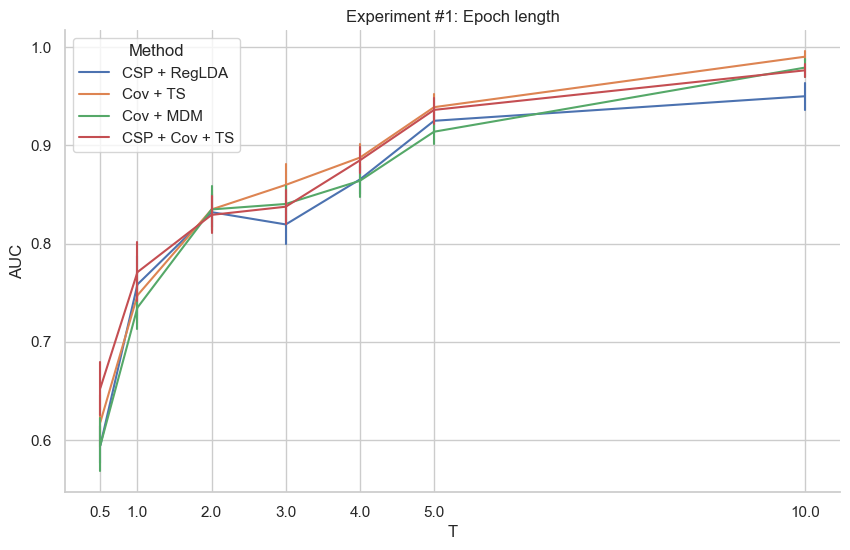

In [100]:
# RESULTS
sns.set_theme(style="whitegrid")
# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(10, 6))
ax.set_title("Experiment #1: Epoch length")
ax.set_xticks(list(T))
# ax.set_xlim(0.4,10.2)

sns.lineplot(data=RESULTS, x='T', y='AUC', 
    hue='Method', 
    # style=
    # col="Method",
    markers=True,
    errorbar=("ci", 68), err_style="bars",
    ax=ax,
) # catplot
sns.despine()